<a href="https://colab.research.google.com/github/BhavGujral/image-diffusion-model/blob/main/Image_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.27MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


Epoch 1 Loss: 0.6273995637893677
Epoch 2 Loss: 0.5791704654693604
Epoch 3 Loss: 0.5666098594665527
Epoch 4 Loss: 0.5668503046035767
Epoch 5 Loss: 0.536001980304718
Epoch 6 Loss: 0.5263494849205017
Epoch 7 Loss: 0.5453643202781677
Epoch 8 Loss: 0.5275993347167969
Epoch 9 Loss: 0.5354700088500977
Epoch 10 Loss: 0.5327942967414856


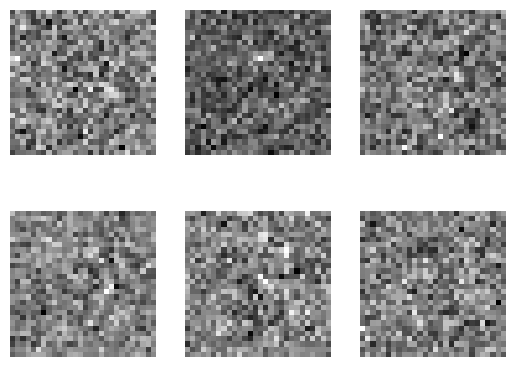

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
T = 1000  # number of diffusion steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Linear beta schedule
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# Simple denoising model (MLP for illustration)
class SimpleDenoiseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)
        )

    def forward(self, x, t):
        return self.net(x)

# Forward diffusion process
def forward_diffusion_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_hat = alpha_hat[t][:, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None]
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Training
model = SimpleDenoiseModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    for x, _ in dataloader:
        x = x.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noisy_x, noise = forward_diffusion_sample(x, t)
        predicted_noise = model(noisy_x, t)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item()}")

# Generate sample by reversing the diffusion
@torch.no_grad()
def sample(model, img_size=28, n_samples=1):
    x = torch.randn(n_samples, img_size * img_size).to(device)
    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        alpha = alphas[t]
        alpha_hat_t = alpha_hat[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * noise_pred) + torch.sqrt(beta) * noise
    return x

# Visualize generated samples
samples = sample(model, n_samples=6).cpu().view(-1, 28, 28)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
@torch.no_grad()
def reverse_diffusion_from_noisy(model, x_noisy, start_t):
    """
    Reconstruct an image starting from a noisy input at timestep `start_t`.
    Args:
        model: Trained denoising model
        x_noisy: Noisy image (batch_size x 784)
        start_t: Integer timestep from which to begin denoising
    Returns:
        Denoised image after full reverse process
    """
    x = x_noisy.clone().to(device)
    for t in reversed(range(start_t)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch)
        alpha = alphas[t]
        alpha_hat_t = alpha_hat[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta) * noise

    return x

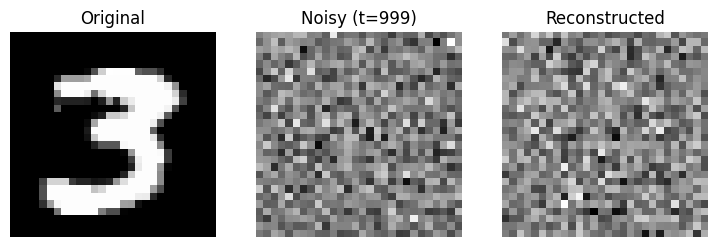

In [ ]:
# Get one image from dataset
test_img, _ = dataset[27]
test_img = test_img.unsqueeze(0).to(device)  # Shape: (1, 784)

# Add noise at timestep t
t_step = 999
t_tensor = torch.tensor([t_step], device=device)
noisy_img, _ = forward_diffusion_sample(test_img, t_tensor)

# Recover the image using reverse diffusion
reconstructed_img = reverse_diffusion_from_noisy(model, noisy_img, t_step)

# Visualize the original, noisy, and reconstructed image
plt.figure(figsize=(9, 3))
for i, img in enumerate([test_img, noisy_img, reconstructed_img]):
    plt.subplot(1, 3, i+1)
    plt.imshow(img.view(28, 28).cpu(), cmap='gray')
    plt.axis('off')
    plt.title(['Original', f'Noisy (t={t_step})', 'Reconstructed'][i])
plt.show()